# Set up

In [23]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'
#%pip install -U multiprocess
#!conda update conda -y

In [24]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata
## https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
#import multiprocessing as mp # fails on IPython environment
import multiprocess as mp # provides Pool

# Preparation 1

In [25]:
## parameters
verbose              = True
save_results         = False
targets_csv          = True
reload_modules       = True

## source sampling
source_sampling      = True
source_sampling_rate = 0.04 # optimal values depend on kinds of source

## doc settings # The longer sentences become, the less precise pairing becomes
size_measures        = [ 'sp_size', 'sn_size' ]
size_measure         = size_measures[1]
max_doc_size         = 11 # values larger than 10 take considerably longer to complete
min_doc_size         =  5

## preprocessing settings
lower_chars          = True
strip_accents        = False
add_boundaries       = True
boundary_symbol      = '#'  # requires more processing resource
if add_boundaries:
    hash_status = "-hashed"
else:
    hash_status = ""

## term settings
ngram_is_inclusive    = True # takes longer to complete but invites sum error if False with larger n, 
inclusion_degree      = 1    # Valid values are {0, 1, 2, ..., None}. With k, n-grams includes (n-k)-grams
print(f"inclusion_degree: {inclusion_degree}")

max_gap_size_factor   = 0.6 # It takes time at valuers larger than 0.5 with larger n such as n = 5
max_gap_size          = round(max_doc_size * max_gap_size_factor) # This needs to be smaller than other cases.
print(f"max_gap_size: {max_gap_size}")

## Skippy n-gram の隙間を表わす記号
gap_mark            = "…"

## spell term と sound term の連結記号
pair_mark           = " :: "

## set spell term_type
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5gram',
                 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
sp_term_type   = sp_term_types[4]
print(f"sp_term_type: {sp_term_type}")

## set sound term_type
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5gram',
                 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
sn_term_type = sn_term_types[4]
print(f"sn_term_type: {sn_term_type}")

## n_for_ngram
n_sp = sp_term_type.split("gram")[0][-1]
n_sn = sn_term_type.split("gram")[0][-1]
n_for_ngram = max(int(n_sp), int(n_sn))
print(f"n_for_ngram: {n_for_ngram}")

inclusion_degree: 1
max_gap_size: 7
sp_term_type: sp_5gram
sn_term_type: sn_5gram
n_for_ngram: 5


In [26]:
## term filtering: some combinations cause "Not all rows sum to 1" error with HDP, but no with LDA
apply_term_freq_filtering  = True
term_minfreq               = 2 # Effective for speeding up
apply_term_abuse_filtering = True
term_abuse_threshold       = 0.1 # Larger values reveal deeper; 0.006 seems to be the smallest

In [27]:
## select HDP or LDA: HDP takes considerably longer to complete than LDA with large n_topics,
## HDP
use_HDP         = True
if use_HDP:
    method_name  = "HDP" # non-executive variable to be used in file names
else:
    method_name  = "LDA"
print(f"method_name: {method_name}")

max_n_topics    = 70
print(f"max_n_topics for HDP: {max_n_topics}")

## LDA
n_topics  = max_n_topics # 精度にはあまり影響しない？
print(f"n_topics for LDA: {n_topics}")

##
n_docs_to_show  = 30
n_terms_to_show = 100
print(f"n_docs_to_show: {n_docs_to_show}")
print(f"n_terms_to_show: {n_terms_to_show}")

## tSNE
top_perplexity_reduct_rate = 0.33
print(f"top_perplexity_reduct_rate: {top_perplexity_reduct_rate}")

# saving output
save_LDAvis          = False
save_topic_structure = False
print(f"save_LDAvis: {save_LDAvis}")
print(f"save_topic_structure: {save_topic_structure}")

# hierarchical clustering
hc_sampling_rate = 0.01
print(f"hc_sampling_rate: {hc_sampling_rate}")

method_name: HDP
max_n_topics for HDP: 70
n_topics for LDA: 70
n_docs_to_show: 30
n_terms_to_show: 100
top_perplexity_reduct_rate: 0.33
save_LDAvis: False
save_topic_structure: False
hc_sampling_rate: 0.01


In [28]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
files = [ ]
for dir in [ data_dir1, data_dir2 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    files.extend(txt_files)
#
files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [29]:
## select language and file
lang_names = {  'ar' : 'Arabic',  # 0
                'de' : 'German',  # 1
                'en' : 'English', # 2
                'es' : 'Spanish', # 3
                'fr' : 'French',  # 4
                'sw' : 'Swahili'  # 5
            }
#
lang_keys = [ 'ar', 'de', 'en', 'es', 'fr', 'sw' ]
#
lang_key  = lang_keys[2]
lang_name = lang_names[lang_key]
lang_attr = ""
print(f"lang_name: {lang_name} ({lang_attr}) [lang_key: {lang_key}]")
# aliases
target_lang_dict = lang_names
target_lang_keys = lang_keys
target_lang_key  = lang_key
target_lang_attr = lang_attr
#
files = [ file for file in files if f"/{lang_key}" in file ]
print(files)
if len(lang_attr) > 0:
    print(f"lang_attr: {lang_attr}")
    selected_files = [ file for file in files if lang_attr in file ]
else:
    selected_files = files
selected_files
if len(selected_files) == 0:
    exit()

lang_name: English () [lang_key: en]
['data/open-dict-ipa/data1/en_US.csv.gz', 'data/open-dict-ipa/data1/en_UK.csv.gz', 'data/open-dict-ipa/data1/en_US.csv']


In [30]:
## build data from files
import re, unicodedata
import pandas as pd

check = False
target_file = selected_files[0]
col_names = [ 'sp_word', 'sn_word' ]
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,'bout,/ˈbaʊt/
1,'cause,/kəz/
2,'course,/ˈkɔɹs/
3,'cuse,/ˈkjuz/
4,'em,/əm/
...,...,...
125922,zysk,/ˈzaɪsk/
125923,zyskowski,/zɪˈskɔfski/
125924,zyuganov,"/ˈzjuɡɑnɑv/, /ˈzuɡɑnɑv/"
125925,zyuganov's,"/ˈzjuɡɑnɑvz/, /ˈzuɡɑnɑvz/"


In [31]:
## modify spell
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: x.split(",")[0]) # pick up only the first
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,'bout,ˈbaʊt
1,'cause,kəz
2,'course,ˈkɔɹs
3,'cuse,ˈkjuz
4,'em,əm
...,...,...
125922,zysk,ˈzaɪsk
125923,zyskowski,zɪˈskɔfski
125924,zyuganov,ˈzjuɡɑnɑv
125925,zyuganov's,ˈzjuɡɑnɑvz


In [32]:
## build df
dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
for i, row in raw_df.iterrows():
    spell = row['sp_word']
    sound = row['sn_word']
    if len(spell) > 0 and len(sound) > 0:
        dids.append(i + 1)
        sids.append(i + 1)
        Spells.append(spell)
        Sounds.append(sound)
#
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_size', 'sn_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_sk2gram', 'sp_sk3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_sk2gram', 'sn_sk3gram' ]
df = pd.DataFrame()
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
#
df[var_names[:4]]

,did,sid,sp_word,sn_word
0,1,1,'bout,ˈbaʊt
1,2,2,'cause,kəz
2,3,3,'course,ˈkɔɹs
3,4,4,'cuse,ˈkjuz
4,5,5,'em,əm
...,...,...,...,...
125922,125923,125923,zysk,ˈzaɪsk
125923,125924,125924,zyskowski,zɪˈskɔfski
125924,125925,125925,zyuganov,ˈzjuɡɑnɑv
125925,125926,125926,zyuganov's,ˈzjuɡɑnɑvz


In [33]:
# filter hyphenated words
len1 = len(df)
df = df[ df['sp_word'].apply(lambda x: x.find("-")) < 0 ]
print(f"discarded {len1- len(df)} rows")

discarded 1011 rows


In [34]:
## tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
if verbose:
    df

In [35]:
## add size columns
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

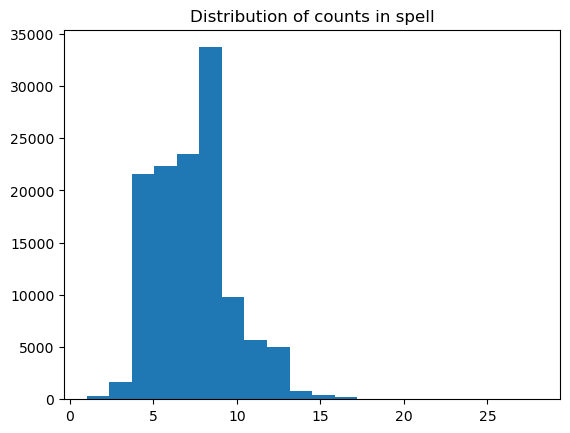

In [36]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_size'], bins = 20)
plt.title(f"Distribution of counts in spell")
plt.show()

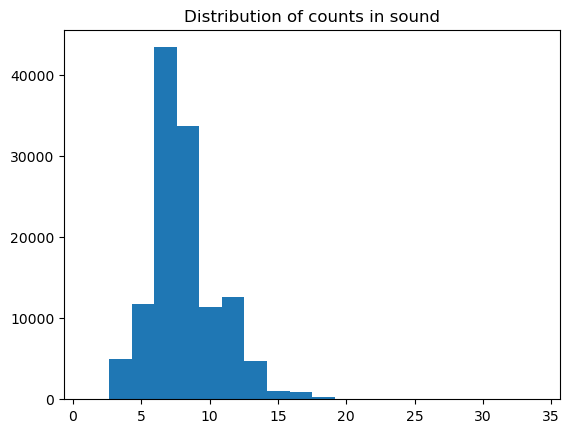

In [37]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_size'], bins = 20)
plt.title(f"Distribution of counts in sound")
plt.show()

In [38]:
## sampling
if source_sampling:
    original_size = len(df)
    sample_size   = round(len(df) * source_sampling_rate)
    df = df.sample(sample_size)
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

sampled 4997 (0.040) rows by discarding 119919 rows


# build terms, part 1

In [39]:
## 長さで濾過
original_size = len(df)
print(f"discarding pairs whose {size_measure} part has less than {min_doc_size} chars")
df = df[df[size_measure] >= min_doc_size]

print(f"discarding pairs whose {size_measure} part has more than {max_doc_size} chars")
df = df[df[size_measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_size part has less than 5 chars
discarding pairs whose sn_size part has more than 11 chars
968 (0.194) pairs were removed
4029 pairs remain


In [40]:
## add boundaries
if add_boundaries:
    df['sp_word'] = df['sp_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df['sn_word'] = df['sn_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df[['sp_word', 'sn_word']]

In [41]:
## add 1gram
import re
w_splitter = r""
#df['sp_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sp_word'] ]
df['sp_1gram'] = df['sp_word'].apply(lambda w: [ x for x in re.split(w_splitter, w) if len(x) > 0 ])
#df['sn_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sn_word'] ]
df['sn_1gram'] = df['sn_word'].apply(lambda w: [ x for x in re.split(w_splitter, w) if len(x) > 0 ])
#
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
9547,"[#, b, e, l, l, y, a, c, h, e, #]","[#, ˈ, b, ɛ, ɫ, i, ˌ, e, ɪ, k, #]"
96196,"[#, r, o, g, n, e, s, s, #]","[#, ˈ, ɹ, ɑ, ɡ, n, ɪ, s, #]"
80319,"[#, o, b, s, e, s, s, i, o, n, a, l, #]","[#, ə, b, ˈ, s, ɛ, ʃ, ə, n, ə, ɫ, #]"
68696,"[#, m, a, l, a, i, s, e, #]","[#, m, æ, ˈ, ɫ, e, ɪ, z, #]"
117375,"[#, u, n, i, s, o, u, r, c, e, #]","[#, ˈ, j, u, n, ɪ, ˌ, s, ɔ, ɹ, s, #]"
...,...,...
14760,"[#, b, r, u, g, m, a, n, #]","[#, ˈ, b, ɹ, ə, ɡ, m, ə, n, #]"
95057,"[#, r, h, o, d, i, e, s, #]","[#, ˈ, ɹ, o, ʊ, d, i, z, #]"
80812,"[#, o, k, e, n, #]","[#, o, ʊ, ˈ, k, e, ɪ, ə, n, #]"
12968,"[#, b, o, s, s, h, a, r, d, t, #]","[#, ˈ, b, ɔ, s, ˌ, h, ɑ, ɹ, t, #]"


In [42]:
## inspect frequent tokens in sp_1gram
from collections import Counter
sp_chars_all = [ ] 
[ sp_chars_all.extend(list(x)) for x in df['sp_1gram'] ]
sp_char_freqs = Counter(sp_chars_all)
## Show most frequent 10 segments
sｐ_char_freqs.most_common(10)

[('#', 8058),
 ('e', 3220),
 ('a', 2433),
 ('r', 2244),
 ('s', 2093),
 ('n', 1975),
 ('i', 1891),
 ('o', 1769),
 ('l', 1700),
 ('t', 1510)]

In [43]:
## inspect frequent tokens in sn_1gram
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('#', 8058),
 ('ˈ', 4047),
 ('ɪ', 1936),
 ('ə', 1843),
 ('n', 1663),
 ('ɫ', 1452),
 ('t', 1399),
 ('s', 1379),
 ('ɹ', 1320),
 ('k', 1221)]

In [44]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [45]:
def gen_ngrams_from_str (t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    segs = [ x for x in re.split(sep, t) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [46]:
## generic n-gram generation function
def add_ngrams (dfx, n_for_ngram: int, prefix: str = "", skippy: bool = False, skippiness_symbol: str = "sk", max_distance = None, seg_joint: str = "", gap_mark: str = "…", inclusive: bool = True, inclusion_degree = None, check: bool = False):
    "add ngram col to the dfx given"
    import gen_ngrams
    ## set variable names
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name  = f"{prefix}{skippiness_symbol}{n_for_ngram}gram"
        if n_for_ngram == 2:
            sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        else:
            sub_var_name = f"{prefix}{skippiness_symbol}{n_for_ngram - 1}gram"
            
    else:
        target_var_name  = f"{prefix}{n_for_ngram}gram"
        sub_var_name     = f"{prefix}{n_for_ngram - 1}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
        print(f"sub_var_name: {sub_var_name}")
        
    ## 1gram
    unigrams = dfx[source_var_name]
    
    ## ngram
    pool = mp.Pool (processes = max(os.cpu_count() - 1, 1))
    if skippy:
        #ngrams = [ gen_ngrams.gen_skippy_ngrams(g, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark,  max_distance = max_distance, check = check) for g in unigrams ]
        ngrams = unigrams.apply(lambda x: gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark, max_distance = max_distance, check = check))
        
    else:
        #ngrams = [ gen_ngrams.gen_ngrams(g, n = n_for_ngram, sep = seg_joint, check = check) for g in unigrams ]
        ngrams = unigrams.apply(lambda x: gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check))
    
    ## make ngrams inclusive
    if inclusive:
        sub_ngrams = list(dfx[sub_var_name])
        if inclusion_degree is None:
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) > 0 ]
                if len(supplement) > 0:
                    gram.extend(supplement)
        else:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) >= min_size ]
                if len(supplement) > 0:
                    gram.extend(supplement)
    ## update df
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

# Spell n-grams 生成

In [47]:
df.columns
#iter(df['sp_1gram'])

Index(['did', 'sid', 'sp_word', 'sn_word', 'sp_1gram', 'sn_1gram', 'sp_size',
       'sn_size'],
      dtype='object')

In [48]:
## sp_2gram の追加
add_ngrams (df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#b, be, el, ll, ly, ya, ac, ch, he, e#, #, b,...
96196     [#r, ro, og, gn, ne, es, ss, s#, #, r, o, g, n...
80319     [#o, ob, bs, se, es, ss, si, io, on, na, al, l...
68696     [#m, ma, al, la, ai, is, se, e#, #, m, a, l, a...
117375    [#u, un, ni, is, so, ou, ur, rc, ce, e#, #, u,...
                                ...                        
14760     [#b, br, ru, ug, gm, ma, an, n#, #, b, r, u, g...
95057     [#r, rh, ho, od, di, ie, es, s#, #, r, h, o, d...
80812                [#o, ok, ke, en, n#, #, o, k, e, n, #]
12968     [#b, bo, os, ss, sh, ha, ar, rd, dt, t#, #, b,...
27758     [#d, de, ef, fe, en, ns, se, es, s#, #, d, e, ...
Name: sp_2gram, Length: 4029, dtype: object


In [49]:
## sp_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#be, bel, ell, lly, lya, yac, ach, che, he#, ...
96196     [#ro, rog, ogn, gne, nes, ess, ss#, #r, ro, og...
80319     [#ob, obs, bse, ses, ess, ssi, sio, ion, ona, ...
68696     [#ma, mal, ala, lai, ais, ise, se#, #m, ma, al...
117375    [#un, uni, nis, iso, sou, our, urc, rce, ce#, ...
                                ...                        
14760     [#br, bru, rug, ugm, gma, man, an#, #b, br, ru...
95057     [#rh, rho, hod, odi, die, ies, es#, #r, rh, ho...
80812              [#ok, oke, ken, en#, #o, ok, ke, en, n#]
12968     [#bo, bos, oss, ssh, sha, har, ard, rdt, dt#, ...
27758     [#de, def, efe, fen, ens, nse, ses, es#, #d, d...
Name: sp_3gram, Length: 4029, dtype: object


In [50]:
## sp_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#bel, bell, elly, llya, lyac, yach, ache, che...
96196     [#rog, rogn, ogne, gnes, ness, ess#, #ro, rog,...
80319     [#obs, obse, bses, sess, essi, ssio, sion, ion...
68696     [#mal, mala, alai, lais, aise, ise#, #ma, mal,...
117375    [#uni, unis, niso, isou, sour, ourc, urce, rce...
                                ...                        
14760     [#bru, brug, rugm, ugma, gman, man#, #br, bru,...
95057     [#rho, rhod, hodi, odie, dies, ies#, #rh, rho,...
80812                [#oke, oken, ken#, #ok, oke, ken, en#]
12968     [#bos, boss, ossh, ssha, shar, hard, ardt, rdt...
27758     [#def, defe, efen, fens, ense, nses, ses#, #de...
Name: sp_4gram, Length: 4029, dtype: object


In [51]:
## sp_5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#bell, belly, ellya, llyac, lyach, yache, ach...
96196     [#rogn, rogne, ognes, gness, ness#, #rog, rogn...
80319     [#obse, obses, bsess, sessi, essio, ssion, sio...
68696     [#mala, malai, alais, laise, aise#, #mal, mala...
117375    [#unis, uniso, nisou, isour, sourc, ource, urc...
                                ...                        
14760     [#brug, brugm, rugma, ugman, gman#, #bru, brug...
95057     [#rhod, rhodi, hodie, odies, dies#, #rho, rhod...
80812                      [#oken, oken#, #oke, oken, ken#]
12968     [#boss, bossh, ossha, sshar, shard, hardt, ard...
27758     [#defe, defen, efens, fense, enses, nses#, #de...
Name: sp_5gram, Length: 4029, dtype: object


In [52]:
## sp_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#b, #…e, #…l, #…l, #…y, #…a, be, b…l, b…l, b…...
96196     [#r, #…o, #…g, #…n, #…e, #…s, ro, r…g, r…n, r…...
80319     [#o, #…b, #…s, #…e, #…s, #…s, ob, o…s, o…e, o…...
68696     [#m, #…a, #…l, #…a, #…i, #…s, ma, m…l, m…a, m…...
117375    [#u, #…n, #…i, #…s, #…o, #…u, un, u…i, u…s, u…...
                                ...                        
14760     [#b, #…r, #…u, #…g, #…m, #…a, br, b…u, b…g, b…...
95057     [#r, #…h, #…o, #…d, #…i, #…e, rh, r…o, r…d, r…...
80812     [#o, #…k, #…e, #…n, #…#, ok, o…e, o…n, o…#, ke...
12968     [#b, #…o, #…s, #…s, #…h, #…a, bo, b…s, b…s, b…...
27758     [#d, #…e, #…f, #…e, #…n, #…s, de, d…f, d…e, d…...
Name: sp_sk2gram, Length: 4029, dtype: object


In [53]:
## sp_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#be, #b…l, #b…l, #b…y, #b…a, #…el, #…e…l, #…e...
96196     [#ro, #r…g, #r…n, #r…e, #r…s, #…og, #…o…n, #…o...
80319     [#ob, #o…s, #o…e, #o…s, #o…s, #…bs, #…b…e, #…b...
68696     [#ma, #m…l, #m…a, #m…i, #m…s, #…al, #…a…a, #…a...
117375    [#un, #u…i, #u…s, #u…o, #u…u, #…ni, #…n…s, #…n...
                                ...                        
14760     [#br, #b…u, #b…g, #b…m, #b…a, #…ru, #…r…g, #…r...
95057     [#rh, #r…o, #r…d, #r…i, #r…e, #…ho, #…h…d, #…h...
80812     [#ok, #o…e, #o…n, #o…#, #…ke, #…k…n, #…k…#, #…...
12968     [#bo, #b…s, #b…s, #b…h, #b…a, #…os, #…o…s, #…o...
27758     [#de, #d…f, #d…e, #d…n, #d…s, #…ef, #…e…e, #…e...
Name: sp_sk3gram, Length: 4029, dtype: object


In [54]:
## sp_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#bel, #be…l, #be…y, #be…a, #b…ll, #b…l…y, #b…...
96196     [#rog, #ro…n, #ro…e, #ro…s, #r…gn, #r…g…e, #r…...
80319     [#obs, #ob…e, #ob…s, #ob…s, #o…se, #o…s…s, #o…...
68696     [#mal, #ma…a, #ma…i, #ma…s, #m…la, #m…l…i, #m…...
117375    [#uni, #un…s, #un…o, #un…u, #u…is, #u…i…o, #u…...
                                ...                        
14760     [#bru, #br…g, #br…m, #br…a, #b…ug, #b…u…m, #b…...
95057     [#rho, #rh…d, #rh…i, #rh…e, #r…od, #r…o…i, #r…...
80812     [#oke, #ok…n, #ok…#, #o…en, #o…e…#, #o…n#, #…k...
12968     [#bos, #bo…s, #bo…h, #bo…a, #b…ss, #b…s…h, #b…...
27758     [#def, #de…e, #de…n, #de…s, #d…fe, #d…f…n, #d…...
Name: sp_sk4gram, Length: 4029, dtype: object


In [55]:
## sp_sk5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#bell, #bel…y, #bel…a, #be…ly, #be…l…a, #be…y...
96196     [#rogn, #rog…e, #rog…s, #ro…ne, #ro…n…s, #ro…e...
80319     [#obse, #obs…s, #obs…s, #ob…es, #ob…e…s, #ob…s...
68696     [#mala, #mal…i, #mal…s, #ma…ai, #ma…a…s, #ma…i...
117375    [#unis, #uni…o, #uni…u, #un…so, #un…s…u, #un…o...
                                ...                        
14760     [#brug, #bru…m, #bru…a, #br…gm, #br…g…a, #br…m...
95057     [#rhod, #rho…i, #rho…e, #rh…di, #rh…d…e, #rh…i...
80812     [#oken, #oke…#, #ok…n#, #o…en#, #…ken#, oken#,...
12968     [#boss, #bos…h, #bos…a, #bo…sh, #bo…s…a, #bo…h...
27758     [#defe, #def…n, #def…s, #de…en, #de…e…s, #de…n...
Name: sp_sk5gram, Length: 4029, dtype: object


In [56]:
## check result
if "5gram" in sp_term_type:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
else:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
df[var_names]

,sp_word,sp_sk2gram,sp_sk3gram,sp_sk4gram,sp_sk5gram
9547,#bellyache#,"[#b, #…e, #…l, #…l, #…y, #…a, be, b…l, b…l, b…...","[#be, #b…l, #b…l, #b…y, #b…a, #…el, #…e…l, #…e...","[#bel, #be…l, #be…y, #be…a, #b…ll, #b…l…y, #b…...","[#bell, #bel…y, #bel…a, #be…ly, #be…l…a, #be…y..."
96196,#rogness#,"[#r, #…o, #…g, #…n, #…e, #…s, ro, r…g, r…n, r…...","[#ro, #r…g, #r…n, #r…e, #r…s, #…og, #…o…n, #…o...","[#rog, #ro…n, #ro…e, #ro…s, #r…gn, #r…g…e, #r…...","[#rogn, #rog…e, #rog…s, #ro…ne, #ro…n…s, #ro…e..."
80319,#obsessional#,"[#o, #…b, #…s, #…e, #…s, #…s, ob, o…s, o…e, o…...","[#ob, #o…s, #o…e, #o…s, #o…s, #…bs, #…b…e, #…b...","[#obs, #ob…e, #ob…s, #ob…s, #o…se, #o…s…s, #o…...","[#obse, #obs…s, #obs…s, #ob…es, #ob…e…s, #ob…s..."
68696,#malaise#,"[#m, #…a, #…l, #…a, #…i, #…s, ma, m…l, m…a, m…...","[#ma, #m…l, #m…a, #m…i, #m…s, #…al, #…a…a, #…a...","[#mal, #ma…a, #ma…i, #ma…s, #m…la, #m…l…i, #m…...","[#mala, #mal…i, #mal…s, #ma…ai, #ma…a…s, #ma…i..."
117375,#unisource#,"[#u, #…n, #…i, #…s, #…o, #…u, un, u…i, u…s, u…...","[#un, #u…i, #u…s, #u…o, #u…u, #…ni, #…n…s, #…n...","[#uni, #un…s, #un…o, #un…u, #u…is, #u…i…o, #u…...","[#unis, #uni…o, #uni…u, #un…so, #un…s…u, #un…o..."
...,...,...,...,...,...
14760,#brugman#,"[#b, #…r, #…u, #…g, #…m, #…a, br, b…u, b…g, b…...","[#br, #b…u, #b…g, #b…m, #b…a, #…ru, #…r…g, #…r...","[#bru, #br…g, #br…m, #br…a, #b…ug, #b…u…m, #b…...","[#brug, #bru…m, #bru…a, #br…gm, #br…g…a, #br…m..."
95057,#rhodies#,"[#r, #…h, #…o, #…d, #…i, #…e, rh, r…o, r…d, r…...","[#rh, #r…o, #r…d, #r…i, #r…e, #…ho, #…h…d, #…h...","[#rho, #rh…d, #rh…i, #rh…e, #r…od, #r…o…i, #r…...","[#rhod, #rho…i, #rho…e, #rh…di, #rh…d…e, #rh…i..."
80812,#oken#,"[#o, #…k, #…e, #…n, #…#, ok, o…e, o…n, o…#, ke...","[#ok, #o…e, #o…n, #o…#, #…ke, #…k…n, #…k…#, #…...","[#oke, #ok…n, #ok…#, #o…en, #o…e…#, #o…n#, #…k...","[#oken, #oke…#, #ok…n#, #o…en#, #…ken#, oken#,..."
12968,#bosshardt#,"[#b, #…o, #…s, #…s, #…h, #…a, bo, b…s, b…s, b…...","[#bo, #b…s, #b…s, #b…h, #b…a, #…os, #…o…s, #…o...","[#bos, #bo…s, #bo…h, #bo…a, #b…ss, #b…s…h, #b…...","[#boss, #bos…h, #bos…a, #bo…sh, #bo…s…a, #bo…h..."


# Sound n-grams 生成

In [57]:
## sn_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#ˈ, ˈb, bɛ, ɛɫ, ɫi, iˌ, ˌe, eɪ, ɪk, k#, #, ˈ,...
96196     [#ˈ, ˈɹ, ɹɑ, ɑɡ, ɡn, nɪ, ɪs, s#, #, ˈ, ɹ, ɑ, ɡ...
80319     [#ə, əb, bˈ, ˈs, sɛ, ɛʃ, ʃə, ən, nə, əɫ, ɫ#, #...
68696     [#m, mæ, æˈ, ˈɫ, ɫe, eɪ, ɪz, z#, #, m, æ, ˈ, ɫ...
117375    [#ˈ, ˈj, ju, un, nɪ, ɪˌ, ˌs, sɔ, ɔɹ, ɹs, s#, #...
                                ...                        
14760     [#ˈ, ˈb, bɹ, ɹə, əɡ, ɡm, mə, ən, n#, #, ˈ, b, ...
95057     [#ˈ, ˈɹ, ɹo, oʊ, ʊd, di, iz, z#, #, ˈ, ɹ, o, ʊ...
80812     [#o, oʊ, ʊˈ, ˈk, ke, eɪ, ɪə, ən, n#, #, o, ʊ, ...
12968     [#ˈ, ˈb, bɔ, ɔs, sˌ, ˌh, hɑ, ɑɹ, ɹt, t#, #, ˈ,...
27758     [#d, dɪ, ɪˈ, ˈf, fɛ, ɛn, ns, sə, əz, z#, #, d,...
Name: sn_2gram, Length: 4029, dtype: object


In [58]:
## sn_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#ˈb, ˈbɛ, bɛɫ, ɛɫi, ɫiˌ, iˌe, ˌeɪ, eɪk, ɪk#, ...
96196     [#ˈɹ, ˈɹɑ, ɹɑɡ, ɑɡn, ɡnɪ, nɪs, ɪs#, #ˈ, ˈɹ, ɹɑ...
80319     [#əb, əbˈ, bˈs, ˈsɛ, sɛʃ, ɛʃə, ʃən, ənə, nəɫ, ...
68696     [#mæ, mæˈ, æˈɫ, ˈɫe, ɫeɪ, eɪz, ɪz#, #m, mæ, æˈ...
117375    [#ˈj, ˈju, jun, unɪ, nɪˌ, ɪˌs, ˌsɔ, sɔɹ, ɔɹs, ...
                                ...                        
14760     [#ˈb, ˈbɹ, bɹə, ɹəɡ, əɡm, ɡmə, mən, ən#, #ˈ, ˈ...
95057     [#ˈɹ, ˈɹo, ɹoʊ, oʊd, ʊdi, diz, iz#, #ˈ, ˈɹ, ɹo...
80812     [#oʊ, oʊˈ, ʊˈk, ˈke, keɪ, eɪə, ɪən, ən#, #o, o...
12968     [#ˈb, ˈbɔ, bɔs, ɔsˌ, sˌh, ˌhɑ, hɑɹ, ɑɹt, ɹt#, ...
27758     [#dɪ, dɪˈ, ɪˈf, ˈfɛ, fɛn, ɛns, nsə, səz, əz#, ...
Name: sn_3gram, Length: 4029, dtype: object


In [59]:
## sn_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#ˈbɛ, ˈbɛɫ, bɛɫi, ɛɫiˌ, ɫiˌe, iˌeɪ, ˌeɪk, eɪk...
96196     [#ˈɹɑ, ˈɹɑɡ, ɹɑɡn, ɑɡnɪ, ɡnɪs, nɪs#, #ˈɹ, ˈɹɑ,...
80319     [#əbˈ, əbˈs, bˈsɛ, ˈsɛʃ, sɛʃə, ɛʃən, ʃənə, ənə...
68696     [#mæˈ, mæˈɫ, æˈɫe, ˈɫeɪ, ɫeɪz, eɪz#, #mæ, mæˈ,...
117375    [#ˈju, ˈjun, junɪ, unɪˌ, nɪˌs, ɪˌsɔ, ˌsɔɹ, sɔɹ...
                                ...                        
14760     [#ˈbɹ, ˈbɹə, bɹəɡ, ɹəɡm, əɡmə, ɡmən, mən#, #ˈb...
95057     [#ˈɹo, ˈɹoʊ, ɹoʊd, oʊdi, ʊdiz, diz#, #ˈɹ, ˈɹo,...
80812     [#oʊˈ, oʊˈk, ʊˈke, ˈkeɪ, keɪə, eɪən, ɪən#, #oʊ...
12968     [#ˈbɔ, ˈbɔs, bɔsˌ, ɔsˌh, sˌhɑ, ˌhɑɹ, hɑɹt, ɑɹt...
27758     [#dɪˈ, dɪˈf, ɪˈfɛ, ˈfɛn, fɛns, ɛnsə, nsəz, səz...
Name: sn_4gram, Length: 4029, dtype: object


In [60]:
## sn_5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#ˈbɛɫ, ˈbɛɫi, bɛɫiˌ, ɛɫiˌe, ɫiˌeɪ, iˌeɪk, ˌeɪ...
96196     [#ˈɹɑɡ, ˈɹɑɡn, ɹɑɡnɪ, ɑɡnɪs, ɡnɪs#, #ˈɹɑ, ˈɹɑɡ...
80319     [#əbˈs, əbˈsɛ, bˈsɛʃ, ˈsɛʃə, sɛʃən, ɛʃənə, ʃən...
68696     [#mæˈɫ, mæˈɫe, æˈɫeɪ, ˈɫeɪz, ɫeɪz#, #mæˈ, mæˈɫ...
117375    [#ˈjun, ˈjunɪ, junɪˌ, unɪˌs, nɪˌsɔ, ɪˌsɔɹ, ˌsɔ...
                                ...                        
14760     [#ˈbɹə, ˈbɹəɡ, bɹəɡm, ɹəɡmə, əɡmən, ɡmən#, #ˈb...
95057     [#ˈɹoʊ, ˈɹoʊd, ɹoʊdi, oʊdiz, ʊdiz#, #ˈɹo, ˈɹoʊ...
80812     [#oʊˈk, oʊˈke, ʊˈkeɪ, ˈkeɪə, keɪən, eɪən#, #oʊ...
12968     [#ˈbɔs, ˈbɔsˌ, bɔsˌh, ɔsˌhɑ, sˌhɑɹ, ˌhɑɹt, hɑɹ...
27758     [#dɪˈf, dɪˈfɛ, ɪˈfɛn, ˈfɛns, fɛnsə, ɛnsəz, nsə...
Name: sn_5gram, Length: 4029, dtype: object


In [61]:
## sn_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#ˈ, #…b, #…ɛ, #…ɫ, #…i, #…ˌ, ˈb, ˈ…ɛ, ˈ…ɫ, ˈ…...
96196     [#ˈ, #…ɹ, #…ɑ, #…ɡ, #…n, #…ɪ, ˈɹ, ˈ…ɑ, ˈ…ɡ, ˈ…...
80319     [#ə, #…b, #…ˈ, #…s, #…ɛ, #…ʃ, əb, ə…ˈ, ə…s, ə…...
68696     [#m, #…æ, #…ˈ, #…ɫ, #…e, #…ɪ, mæ, m…ˈ, m…ɫ, m…...
117375    [#ˈ, #…j, #…u, #…n, #…ɪ, #…ˌ, ˈj, ˈ…u, ˈ…n, ˈ…...
                                ...                        
14760     [#ˈ, #…b, #…ɹ, #…ə, #…ɡ, #…m, ˈb, ˈ…ɹ, ˈ…ə, ˈ…...
95057     [#ˈ, #…ɹ, #…o, #…ʊ, #…d, #…i, ˈɹ, ˈ…o, ˈ…ʊ, ˈ…...
80812     [#o, #…ʊ, #…ˈ, #…k, #…e, #…ɪ, oʊ, o…ˈ, o…k, o…...
12968     [#ˈ, #…b, #…ɔ, #…s, #…ˌ, #…h, ˈb, ˈ…ɔ, ˈ…s, ˈ…...
27758     [#d, #…ɪ, #…ˈ, #…f, #…ɛ, #…n, dɪ, d…ˈ, d…f, d…...
Name: sn_sk2gram, Length: 4029, dtype: object


In [62]:
## sn_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#ˈb, #ˈ…ɛ, #ˈ…ɫ, #ˈ…i, #ˈ…ˌ, #…bɛ, #…b…ɫ, #…b...
96196     [#ˈɹ, #ˈ…ɑ, #ˈ…ɡ, #ˈ…n, #ˈ…ɪ, #…ɹɑ, #…ɹ…ɡ, #…ɹ...
80319     [#əb, #ə…ˈ, #ə…s, #ə…ɛ, #ə…ʃ, #…bˈ, #…b…s, #…b...
68696     [#mæ, #m…ˈ, #m…ɫ, #m…e, #m…ɪ, #…æˈ, #…æ…ɫ, #…æ...
117375    [#ˈj, #ˈ…u, #ˈ…n, #ˈ…ɪ, #ˈ…ˌ, #…ju, #…j…n, #…j...
                                ...                        
14760     [#ˈb, #ˈ…ɹ, #ˈ…ə, #ˈ…ɡ, #ˈ…m, #…bɹ, #…b…ə, #…b...
95057     [#ˈɹ, #ˈ…o, #ˈ…ʊ, #ˈ…d, #ˈ…i, #…ɹo, #…ɹ…ʊ, #…ɹ...
80812     [#oʊ, #o…ˈ, #o…k, #o…e, #o…ɪ, #…ʊˈ, #…ʊ…k, #…ʊ...
12968     [#ˈb, #ˈ…ɔ, #ˈ…s, #ˈ…ˌ, #ˈ…h, #…bɔ, #…b…s, #…b...
27758     [#dɪ, #d…ˈ, #d…f, #d…ɛ, #d…n, #…ɪˈ, #…ɪ…f, #…ɪ...
Name: sn_sk3gram, Length: 4029, dtype: object


In [63]:
## sn_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#ˈbɛ, #ˈb…ɫ, #ˈb…i, #ˈb…ˌ, #ˈ…ɛɫ, #ˈ…ɛ…i, #ˈ…...
96196     [#ˈɹɑ, #ˈɹ…ɡ, #ˈɹ…n, #ˈɹ…ɪ, #ˈ…ɑɡ, #ˈ…ɑ…n, #ˈ…...
80319     [#əbˈ, #əb…s, #əb…ɛ, #əb…ʃ, #ə…ˈs, #ə…ˈ…ɛ, #ə…...
68696     [#mæˈ, #mæ…ɫ, #mæ…e, #mæ…ɪ, #m…ˈɫ, #m…ˈ…e, #m…...
117375    [#ˈju, #ˈj…n, #ˈj…ɪ, #ˈj…ˌ, #ˈ…un, #ˈ…u…ɪ, #ˈ…...
                                ...                        
14760     [#ˈbɹ, #ˈb…ə, #ˈb…ɡ, #ˈb…m, #ˈ…ɹə, #ˈ…ɹ…ɡ, #ˈ…...
95057     [#ˈɹo, #ˈɹ…ʊ, #ˈɹ…d, #ˈɹ…i, #ˈ…oʊ, #ˈ…o…d, #ˈ…...
80812     [#oʊˈ, #oʊ…k, #oʊ…e, #oʊ…ɪ, #o…ˈk, #o…ˈ…e, #o…...
12968     [#ˈbɔ, #ˈb…s, #ˈb…ˌ, #ˈb…h, #ˈ…ɔs, #ˈ…ɔ…ˌ, #ˈ…...
27758     [#dɪˈ, #dɪ…f, #dɪ…ɛ, #dɪ…n, #d…ˈf, #d…ˈ…ɛ, #d…...
Name: sn_sk4gram, Length: 4029, dtype: object


In [64]:
## sn_sk5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

9547      [#ˈbɛɫ, #ˈbɛ…i, #ˈbɛ…ˌ, #ˈb…ɫi, #ˈb…ɫ…ˌ, #ˈb…i...
96196     [#ˈɹɑɡ, #ˈɹɑ…n, #ˈɹɑ…ɪ, #ˈɹ…ɡn, #ˈɹ…ɡ…ɪ, #ˈɹ…n...
80319     [#əbˈs, #əbˈ…ɛ, #əbˈ…ʃ, #əb…sɛ, #əb…s…ʃ, #əb…ɛ...
68696     [#mæˈɫ, #mæˈ…e, #mæˈ…ɪ, #mæ…ɫe, #mæ…ɫ…ɪ, #mæ…e...
117375    [#ˈjun, #ˈju…ɪ, #ˈju…ˌ, #ˈj…nɪ, #ˈj…n…ˌ, #ˈj…ɪ...
                                ...                        
14760     [#ˈbɹə, #ˈbɹ…ɡ, #ˈbɹ…m, #ˈb…əɡ, #ˈb…ə…m, #ˈb…ɡ...
95057     [#ˈɹoʊ, #ˈɹo…d, #ˈɹo…i, #ˈɹ…ʊd, #ˈɹ…ʊ…i, #ˈɹ…d...
80812     [#oʊˈk, #oʊˈ…e, #oʊˈ…ɪ, #oʊ…ke, #oʊ…k…ɪ, #oʊ…e...
12968     [#ˈbɔs, #ˈbɔ…ˌ, #ˈbɔ…h, #ˈb…sˌ, #ˈb…s…h, #ˈb…ˌ...
27758     [#dɪˈf, #dɪˈ…ɛ, #dɪˈ…n, #dɪ…fɛ, #dɪ…f…n, #dɪ…ɛ...
Name: sn_sk5gram, Length: 4029, dtype: object


In [65]:
## check result
if "5gram" in sn_term_type:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
else:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
df[var_names]

,sn_word,sn_sk2gram,sn_sk3gram,sn_sk4gram,sn_sk5gram
9547,#ˈbɛɫiˌeɪk#,"[#ˈ, #…b, #…ɛ, #…ɫ, #…i, #…ˌ, ˈb, ˈ…ɛ, ˈ…ɫ, ˈ…...","[#ˈb, #ˈ…ɛ, #ˈ…ɫ, #ˈ…i, #ˈ…ˌ, #…bɛ, #…b…ɫ, #…b...","[#ˈbɛ, #ˈb…ɫ, #ˈb…i, #ˈb…ˌ, #ˈ…ɛɫ, #ˈ…ɛ…i, #ˈ…...","[#ˈbɛɫ, #ˈbɛ…i, #ˈbɛ…ˌ, #ˈb…ɫi, #ˈb…ɫ…ˌ, #ˈb…i..."
96196,#ˈɹɑɡnɪs#,"[#ˈ, #…ɹ, #…ɑ, #…ɡ, #…n, #…ɪ, ˈɹ, ˈ…ɑ, ˈ…ɡ, ˈ…...","[#ˈɹ, #ˈ…ɑ, #ˈ…ɡ, #ˈ…n, #ˈ…ɪ, #…ɹɑ, #…ɹ…ɡ, #…ɹ...","[#ˈɹɑ, #ˈɹ…ɡ, #ˈɹ…n, #ˈɹ…ɪ, #ˈ…ɑɡ, #ˈ…ɑ…n, #ˈ…...","[#ˈɹɑɡ, #ˈɹɑ…n, #ˈɹɑ…ɪ, #ˈɹ…ɡn, #ˈɹ…ɡ…ɪ, #ˈɹ…n..."
80319,#əbˈsɛʃənəɫ#,"[#ə, #…b, #…ˈ, #…s, #…ɛ, #…ʃ, əb, ə…ˈ, ə…s, ə…...","[#əb, #ə…ˈ, #ə…s, #ə…ɛ, #ə…ʃ, #…bˈ, #…b…s, #…b...","[#əbˈ, #əb…s, #əb…ɛ, #əb…ʃ, #ə…ˈs, #ə…ˈ…ɛ, #ə…...","[#əbˈs, #əbˈ…ɛ, #əbˈ…ʃ, #əb…sɛ, #əb…s…ʃ, #əb…ɛ..."
68696,#mæˈɫeɪz#,"[#m, #…æ, #…ˈ, #…ɫ, #…e, #…ɪ, mæ, m…ˈ, m…ɫ, m…...","[#mæ, #m…ˈ, #m…ɫ, #m…e, #m…ɪ, #…æˈ, #…æ…ɫ, #…æ...","[#mæˈ, #mæ…ɫ, #mæ…e, #mæ…ɪ, #m…ˈɫ, #m…ˈ…e, #m…...","[#mæˈɫ, #mæˈ…e, #mæˈ…ɪ, #mæ…ɫe, #mæ…ɫ…ɪ, #mæ…e..."
117375,#ˈjunɪˌsɔɹs#,"[#ˈ, #…j, #…u, #…n, #…ɪ, #…ˌ, ˈj, ˈ…u, ˈ…n, ˈ…...","[#ˈj, #ˈ…u, #ˈ…n, #ˈ…ɪ, #ˈ…ˌ, #…ju, #…j…n, #…j...","[#ˈju, #ˈj…n, #ˈj…ɪ, #ˈj…ˌ, #ˈ…un, #ˈ…u…ɪ, #ˈ…...","[#ˈjun, #ˈju…ɪ, #ˈju…ˌ, #ˈj…nɪ, #ˈj…n…ˌ, #ˈj…ɪ..."
...,...,...,...,...,...
14760,#ˈbɹəɡmən#,"[#ˈ, #…b, #…ɹ, #…ə, #…ɡ, #…m, ˈb, ˈ…ɹ, ˈ…ə, ˈ…...","[#ˈb, #ˈ…ɹ, #ˈ…ə, #ˈ…ɡ, #ˈ…m, #…bɹ, #…b…ə, #…b...","[#ˈbɹ, #ˈb…ə, #ˈb…ɡ, #ˈb…m, #ˈ…ɹə, #ˈ…ɹ…ɡ, #ˈ…...","[#ˈbɹə, #ˈbɹ…ɡ, #ˈbɹ…m, #ˈb…əɡ, #ˈb…ə…m, #ˈb…ɡ..."
95057,#ˈɹoʊdiz#,"[#ˈ, #…ɹ, #…o, #…ʊ, #…d, #…i, ˈɹ, ˈ…o, ˈ…ʊ, ˈ…...","[#ˈɹ, #ˈ…o, #ˈ…ʊ, #ˈ…d, #ˈ…i, #…ɹo, #…ɹ…ʊ, #…ɹ...","[#ˈɹo, #ˈɹ…ʊ, #ˈɹ…d, #ˈɹ…i, #ˈ…oʊ, #ˈ…o…d, #ˈ…...","[#ˈɹoʊ, #ˈɹo…d, #ˈɹo…i, #ˈɹ…ʊd, #ˈɹ…ʊ…i, #ˈɹ…d..."
80812,#oʊˈkeɪən#,"[#o, #…ʊ, #…ˈ, #…k, #…e, #…ɪ, oʊ, o…ˈ, o…k, o…...","[#oʊ, #o…ˈ, #o…k, #o…e, #o…ɪ, #…ʊˈ, #…ʊ…k, #…ʊ...","[#oʊˈ, #oʊ…k, #oʊ…e, #oʊ…ɪ, #o…ˈk, #o…ˈ…e, #o…...","[#oʊˈk, #oʊˈ…e, #oʊˈ…ɪ, #oʊ…ke, #oʊ…k…ɪ, #oʊ…e..."
12968,#ˈbɔsˌhɑɹt#,"[#ˈ, #…b, #…ɔ, #…s, #…ˌ, #…h, ˈb, ˈ…ɔ, ˈ…s, ˈ…...","[#ˈb, #ˈ…ɔ, #ˈ…s, #ˈ…ˌ, #ˈ…h, #…bɔ, #…b…s, #…b...","[#ˈbɔ, #ˈb…s, #ˈb…ˌ, #ˈb…h, #ˈ…ɔs, #ˈ…ɔ…ˌ, #ˈ…...","[#ˈbɔs, #ˈbɔ…ˌ, #ˈbɔ…h, #ˈb…sˌ, #ˈb…s…h, #ˈb…ˌ..."


# Pair = sp term :: sn term の生成

In [66]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_mark}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [67]:
## random sampling
import random
random.sample(random.sample(paired_terms, 1)[0], 20)

['calo :: əˈɫɔ',
 'ric# :: #kəˈ',
 'oric# :: əˈɫɔɹ',
 'lori :: ɹɪk#',
 '#cal :: #kəˈɫ',
 'calo :: #kəˈɫ',
 'calo :: ˈɫɔɹ',
 '#cal :: ɫɔɹɪk',
 'oric# :: kəˈɫ',
 'oric# :: #kəˈ',
 'alori :: kəˈɫ',
 'lori :: #kəˈ',
 'loric :: əˈɫɔ',
 'loric :: ɔɹɪk#',
 'alori :: kəˈɫɔ',
 'calo :: ɫɔɹɪ',
 'alor :: ˈɫɔɹ',
 'calor :: ɫɔɹɪk',
 '#cal :: ˈɫɔɹɪ',
 '#cal :: kəˈɫ']

In [68]:
## number of sentences
print(len(paired_terms))

4029


In [69]:
## total number of units
sum(map(len, paired_terms))

548051

In [70]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
term_type = "paired_term"
df[ ['sp_word', 'sn_word', term_type ] ]

,sp_word,sn_word,paired_term
9547,#bellyache#,#ˈbɛɫiˌeɪk#,"[#bell :: #ˈbɛɫ, #bell :: ˈbɛɫi, #bell :: bɛɫi..."
96196,#rogness#,#ˈɹɑɡnɪs#,"[#rogn :: #ˈɹɑɡ, #rogn :: ˈɹɑɡn, #rogn :: ɹɑɡn..."
80319,#obsessional#,#əbˈsɛʃənəɫ#,"[#obse :: #əbˈs, #obse :: əbˈsɛ, #obse :: bˈsɛ..."
68696,#malaise#,#mæˈɫeɪz#,"[#mala :: #mæˈɫ, #mala :: mæˈɫe, #mala :: æˈɫe..."
117375,#unisource#,#ˈjunɪˌsɔɹs#,"[#unis :: #ˈjun, #unis :: ˈjunɪ, #unis :: junɪ..."
...,...,...,...
14760,#brugman#,#ˈbɹəɡmən#,"[#brug :: #ˈbɹə, #brug :: ˈbɹəɡ, #brug :: bɹəɡ..."
95057,#rhodies#,#ˈɹoʊdiz#,"[#rhod :: #ˈɹoʊ, #rhod :: ˈɹoʊd, #rhod :: ɹoʊd..."
80812,#oken#,#oʊˈkeɪən#,"[#oken :: #oʊˈk, #oken :: oʊˈke, #oken :: ʊˈke..."
12968,#bosshardt#,#ˈbɔsˌhɑɹt#,"[#boss :: #ˈbɔs, #boss :: ˈbɔsˌ, #boss :: bɔsˌ..."


In [71]:
## select data type and define doc_dict
import random
#doc_dict = { i: x for i, x in enumerate(df['paired_term']) }
sn_dict = { i: x for i, x in enumerate(df['sn_word']) }
sp_dict = { i: x for i, x in enumerate(df['sp_word']) }
## check
#random.sample(list(doc_dict.items()), 3)
#random.sample(list(sn_dict.items()), 5)
random.sample(list(zip(sp_dict.values(), sn_dict.values())), 10)

[('#rogoff#', '#ˈɹɑɡɔf#'),
 ('#allowable#', '#əˈɫaʊəbəɫ#'),
 ('#unshackled#', '#ənˈʃækəɫd#'),
 ('#suites#', '#ˈswits#'),
 ('#vida#', '#ˈvaɪdə#'),
 ('#ranes#', '#ˈɹeɪnz#'),
 ('#arnault#', '#ˌɑɹˈnoʊ#'),
 ('#graye#', '#ˈɡɹeɪ#'),
 ('#newbury#', '#ˈnuˌbɛɹi#'),
 ('#pathetic#', '#pəˈθɛtɪk#')]

# LDA/HDP の実行

In [72]:
## build DTM
from gensim.corpora.dictionary import Dictionary

pair_bots = df[term_type]
pair_diction = Dictionary(pair_bots)

## check
print(pair_diction) # print(..) is required for inspection

Dictionary<515383 unique tokens: ['#bel :: #ˈbɛ', '#bel :: #ˈbɛɫ', '#bel :: bɛɫi', '#bel :: bɛɫiˌ', '#bel :: eɪk#']...>


In [73]:
## filter DTM
import copy
pair_diction_copy = copy.deepcopy(pair_diction)

if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")
## check
print(pair_diction)

min freq filter: 2
abuse filter: 0.1
term filtering applied
Dictionary<23090 unique tokens: ['#bel :: #ˈbɛ', '#bel :: #ˈbɛɫ', '#bel :: ˈbɛɫ', '#bell :: #ˈbɛ', '#bell :: #ˈbɛɫ']...>


In [74]:
## build corpus
print(f"Building pair corpus ...")
pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots ]
print(f"Number of documents: {len(pair_corpus)}")

## sanitize corpus for HDP model
size0 = len(pair_corpus)
pair_corpus = [ doc for doc in pair_corpus if len(doc) > 0 ]
size1 = len(pair_corpus)
print(f"{size0 - size1} empty docs are removed out from pair_corpus")
check = False
if check:
    print(random.sample(pair_corpus, 3))

Building pair corpus ...
Number of documents: 4029
520 empty docs are removed out from pair_corpus


In [75]:
## build model: takes quite a while when complex terms are selected
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    ## the outcome of the following needs to be checked to avoid "Not all rows sum to 1 error".
    pair_hdp = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, T = max_n_topics)
    print(pair_hdp)
    pair_lda = pair_hdp.hdp_to_lda()
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_lda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
    ## check results
    print(pair_lda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 70


# pyLDAvis の実行

In [76]:
##!conda install pyLDAvis
#!pip install pyLDAvis
#!conda update conda -y

In [77]:
%%capture --no-display

## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

## set variable names
if use_HDP:
    model_used  = pair_hdp
else:
    model_used  = pair_lda
corpus_used   = pair_corpus
diction_used  = pair_diction

## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
##
pyLDAvis.display(vis_data)

In [78]:
## save LDAvis output as a html file
save_LDAvis = save_LDAvis
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = 0
	if len(lang_attr) > 0:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{lang_attr}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"
	else:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"	
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [79]:
## save topic structures
hdp_topics = pair_hdp.show_topics(num_topics = max_n_topics,
                               num_words = n_terms_to_show, formatted = False)
hdp_dict = { tid: values for tid, values in hdp_topics }
## convert to Pandas dataframe
topics_df = pd.DataFrame.from_dict(hdp_dict)
lang_dir_name = lang_name
target_class = "pair"
term_type = f"{sp_term_type}-{sn_term_type}"
accent_status = "-unaccented"
#
pair_hdp_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}-{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
topics_df.to_csv(pair_hdp_topics_out, header = False, index = None)

# t-SNE を使った可視化

In [80]:
## t-SNE の実行
from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
top_perplexity_val = round(n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, max_iter = 1000)
## データに適用
pair_top_dist = model_used.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 23


In [81]:
## tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])

## 3D 散布図にラベルを追加する処理は未実装
#method = "HDP" if use_HDP else "LDA"
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {n_topics} topics from {method_name} (term: {sp_term_type}-{sn_term_type}")
fig.show()

In [82]:
## stop if HDP is used
if use_HDP:
    #sys.exit(0)
    pass

# Topic structure inspection

In [83]:
## derive LDA from HDP
pair_lda = pair_hdp.suggested_lda_model()

In [84]:
## topic investigation
import HDP_helper

target_hdp = pair_hdp
documents_topics = np.zeros([target_hdp.m_T, len(pair_corpus)])
for doc_id, c in enumerate(pair_corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        #doc = doc_dict[doc_id]
        sp = sp_dict[doc_id]
        sn = sn_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {sp} :: {sn}")

topic_id 0: 0.0 * #tal :: #ˈtæɫ + 0.0 * igan# :: ɪɡən# + 0.0 * #din :: ˈdɪŋ + 0.0 * ckwor :: ˌkwɝk + 0.0 * erda :: ɝˌdæm + 0.0 * ble# :: bəɫ# + 0.0 * #bra :: #ˈbɹæ + 0.0 * tive# :: tɪv# + 0.0 * dicat :: dəˌk + 0.0 * #pars :: #ˈpɑɹ + 0.0 * #cen :: sɛntɝ + 0.0 * erbe :: ˈhɝb + 0.0 * #seib :: saɪb + 0.0 * ffle :: fəɫ# + 0.0 * rece :: ɹiˈs + 0.0 * enni :: nɪɡən + 0.0 * enni :: ɪɡən# + 0.0 * ndor :: nˈdɔɹ + 0.0 * gerar :: ɝˈɑɹ + 0.0 * good# :: ˌɡʊd# + 0.0 * nts# :: ənts# + 0.0 * ncie :: siz# + 0.0 * #mal :: mæɫəˈ + 0.0 * fires :: #ˈfaɪ + 0.0 * #pit :: ˈpɪtɪ + 0.0 * #lind :: ɫɪnd + 0.0 * #car :: kɛɹi + 0.0 * ator# :: eɪtɝ# + 0.0 * niga :: ɪɡən# + 0.0 * ndon# :: ndɪn + 0.0 * ils# :: əɫz# + 0.0 * ndan :: ndən + 0.0 * niga :: ɪɡən + 0.0 * ting :: tɪŋ# + 0.0 * eide :: aɪdɝ + 0.0 * ather :: wɛðɝˌ + 0.0 * #atr :: #ˈeɪ + 0.0 * light :: ˈsɫaɪ + 0.0 * ehar :: hɑɹt + 0.0 * stock :: #ˈstɑ + 0.0 * ing# :: ŋɪŋ# + 0.0 * #rob :: ˈɹɑbɪ + 0.0 * eppn :: pnɝ# + 0.0 * able# :: əbəɫ# + 0.0 * park :: pɑɹkɪ + 0.0 

In [85]:
if reload_modules:
    import importlib
    importlib.reload (HDP_helper)

1386 rows remain after density filtering, discarding 21704 rows
1386 rows remain after size filtering, discarding 0 rows
139 rows remain after size filtering, discarding 1247 rows


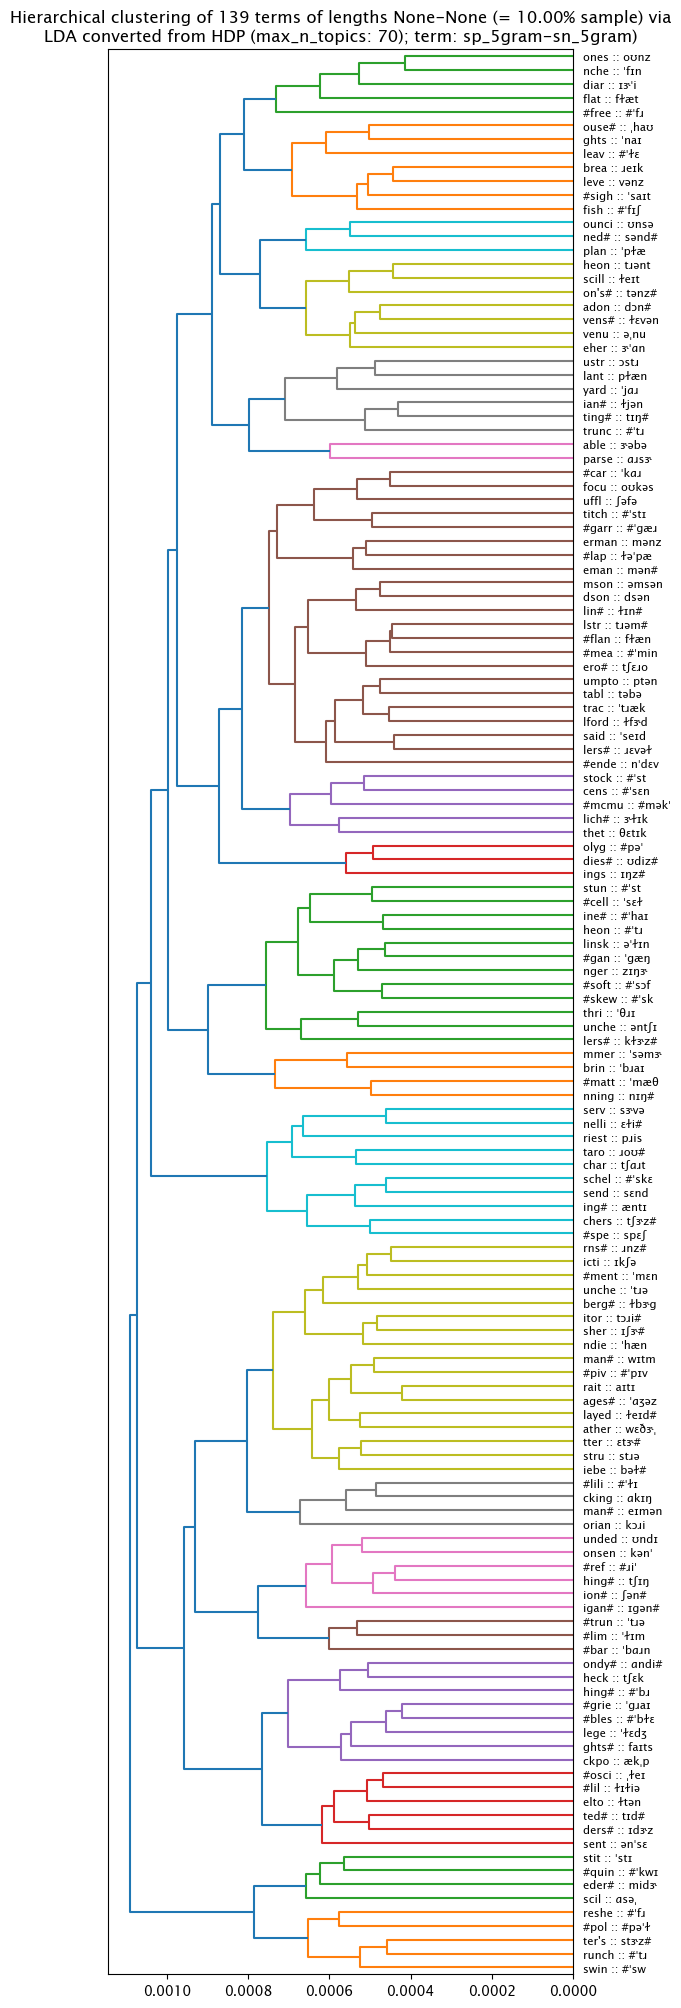

In [86]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
## なるべく高い lowerst_density の設定が肝
HDP_helper.hc_clustering_terms_from_hdp (pair_hdp, pair_diction, term_type = term_type, n_topics= max_n_topics, lowest_density = 0.0036, sampling_rate = 0.1, gap_mark = gap_mark, use_CJK = False, check = False)

In [87]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = n_terms_to_show # topic ごとに表示する term 数の指定
print(f"n_terms_to_show: {n_terms_to_show}")

pair_topic_dfs = [ ]
for topic_id in range(max_n_topics):
    print(f"topic_id: {topic_id}")
    pair_terms = [ ]
    if use_HDP:
        for i, prob in pair_lda.show_topics(topic_id, num_words = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    else:
        for i, prob in model_used.get_topic_terms(topic_id, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic_id}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)

## Table として表示
#df_terms_by_topics.T
df_terms_by_topics

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
topic 0,#buc :: əɫtɝ#,comp :: kəmˈp,#buc :: ɫtɝ#,#com :: #kəm,rce# :: ɔɹs#,#com :: kəmˈp,#comp :: kəmˈp,comp :: #kəm,#uni :: #ˈju,#uni :: junɪ,...,nal# :: ənəɫ#,#bel :: #ˈbɛ,#bel :: ˈbɛɫ,bell :: ˈbɛɫ,elly :: ɛɫiˌ,onal# :: nəɫ#,#bel :: #ˈbɛɫ,nal# :: nəɫ#,#bell :: #ˈbɛɫ,bell :: #ˈbɛ
topic 1,bell :: #ˈbɛ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 2,#buc :: əɫtɝ#,bell :: #ˈbɛ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 3,#buc :: əɫtɝ#,#bell :: #ˈbɛɫ,bell :: #ˈbɛ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic 4,#buc :: əɫtɝ#,comp :: kəmˈp,#bell :: #ˈbɛɫ,bell :: #ˈbɛ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
topic 65,#buc :: əɫtɝ#,comp :: kəmˈp,#buc :: ɫtɝ#,rce# :: ɔɹs#,#com :: #kəm,comp :: #kəm,#com :: kəmˈp,#comp :: kəmˈp,#uni :: junɪ,#uni :: #ˈju,...,onal# :: nəɫ#,#bel :: #ˈbɛɫ,nal# :: nəɫ#,#bell :: #ˈbɛɫ,bell :: #ˈbɛ,NaN,NaN,NaN,NaN,NaN
topic 66,#buc :: əɫtɝ#,comp :: kəmˈp,#buc :: ɫtɝ#,rce# :: ɔɹs#,#com :: #kəm,comp :: #kəm,#comp :: kəmˈp,#com :: kəmˈp,#uni :: junɪ,#uni :: #ˈju,...,elly :: ɛɫiˌ,onal# :: nəɫ#,#bel :: #ˈbɛɫ,nal# :: nəɫ#,#bell :: #ˈbɛɫ,bell :: #ˈbɛ,NaN,NaN,NaN,NaN
topic 67,#buc :: əɫtɝ#,comp :: kəmˈp,#buc :: ɫtɝ#,#com :: #kəm,rce# :: ɔɹs#,#com :: kəmˈp,comp :: #kəm,#comp :: kəmˈp,#uni :: junɪ,#uni :: #ˈju,...,bell :: ˈbɛɫ,elly :: ɛɫiˌ,onal# :: nəɫ#,#bel :: #ˈbɛɫ,nal# :: nəɫ#,#bell :: #ˈbɛɫ,bell :: #ˈbɛ,NaN,NaN,NaN
topic 68,#buc :: əɫtɝ#,comp :: kəmˈp,#buc :: ɫtɝ#,rce# :: ɔɹs#,#com :: #kəm,comp :: #kəm,#com :: kəmˈp,#comp :: kəmˈp,#uni :: #ˈju,#uni :: junɪ,...,#bel :: ˈbɛɫ,bell :: ˈbɛɫ,elly :: ɛɫiˌ,onal# :: nəɫ#,#bel :: #ˈbɛɫ,nal# :: nəɫ#,#bell :: #ˈbɛɫ,bell :: #ˈbɛ,NaN,NaN
